In [12]:
import numpy as np
import tensorflow as tf
from Seq2Seq import helpers

In [13]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [14]:
PAD = 0
EOS = 1
vocab_size = 10
batch_size = 2
max_time = 3
input_embedding_size = 20
encoder_hidden_units = 25
decoder_hidden_units = encoder_hidden_units

In [15]:
# encoder_inputs:[max_time, batch_size]
encoder_inputs = tf.placeholder(shape=(batch_size, max_time), dtype=tf.int32, name='encoder_inputs')
# decoder_targets: [max_time, batch_size]
decoder_targets = tf.placeholder(shape=(batch_size, max_time), dtype=tf.int32, name='decoder_targets')
# decoder_inputs: [max_time, batch_size]
decoder_inputs = tf.placeholder(shape=(batch_size, max_time), dtype=tf.int32, name='decoder_inputs')

In [16]:
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0),
                         dtype=tf.float32)
# encoder_inputs_embeded: [max_time, batch_size, input_embedding_size]
encoder_inputs_embeded = tf.nn.embedding_lookup(embeddings, encoder_inputs)
# decoder_inputs_embeded: [max_time, batch_size, input_embedding_size]
decoder_inputs_embeded = tf.nn.embedding_lookup(embeddings, decoder_inputs)
decoder_inputs_embeded

<tf.Tensor 'embedding_lookup_1:0' shape=(2, 3, 20) dtype=float32>

In [17]:
encoder_cell = tf.contrib.rnn.LSTMCell(encoder_hidden_units)
encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(encoder_cell,
                                                         encoder_inputs_embeded,
                                                         dtype=tf.float32, time_major=True)
del encoder_outputs
encoder_final_state

LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 25) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 25) dtype=float32>)

In [18]:
encoder_cell

In [19]:
decoder_cell = tf.contrib.rnn.LSTMCell(decoder_hidden_units)
decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(decoder_cell, 
                                                         decoder_inputs_embeded,
                                                         initial_state=encoder_final_state,
                                                         dtype=tf.float32, time_major=True,
                                                         scope='plain_decoder')
decoder_outputs

<tf.Tensor 'plain_decoder/TensorArrayStack/TensorArrayGatherV3:0' shape=(2, 3, 25) dtype=float32>

In [20]:
decoder_final_state

In [22]:
decoder_logits = tf.contrib.layers.linear(decoder_outputs, vocab_size)
decoder_prediction = tf.argmax(decoder_logits, 2)
decoder_logits

<tf.Tensor 'fully_connected_1/BiasAdd:0' shape=(2, 3, 10) dtype=float32>

In [125]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, 
                      depth=vocab_size, 
                      dtype=tf.float32),
    logits=decoder_logits)

In [126]:
loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

In [127]:
sess.run(tf.global_variables_initializer())

In [128]:
batch_ = [[6], [3, 4], [9, 8, 7]]

batch_, batch_length_ = helpers.batch(batch_)
print('batch_encoded:\n' + str(batch_))

din_, dlen_ = helpers.batch(np.ones(shape=(3, 1), dtype=np.int32),
                            max_sequence_length=4)
print('decoder inputs:\n' + str(din_))

pred_ = sess.run(decoder_prediction,
                 feed_dict={encoder_inputs: batch_,
                            decoder_inputs: din_,})
print('decoder predictions:\n' + str(pred_))

batch_encoded:
[[6 3 9]
 [0 4 8]
 [0 0 7]]
decoder inputs:
[[1 1 1]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
decoder predictions:
[[2 2 2]
 [0 0 4]
 [0 0 4]
 [0 0 4]]


In [130]:
batch_size = 100
batches = helpers.random_sequences(length_from=3, length_to=8, vocab_lower=2, 
                                   vocab_upper=10, batch_size=batch_size)
# print('head of the batch')
# for seq in next(bat+dltches):
#     print(seq)

In [131]:
# coding=utf-8
def next_feed():
    batch = next(batches)
    encoder_inputs_, _ = helpers.batch(batch)
    # print('encoder_inputs_shape{:}'.format(np.shape(encoder_inputs_)))
    decoder_targets_, _ = helpers.batch(
        [(sequence) + [EOS] for sequence in batch]
    )
    # print('decoder_target_shape{:}'.format(np.shape(decoder_targets_)))

    # decoder_inputs_, _ = helpers.batch(
    #     [[EOS] + (sequence) for sequence in batch]
    # )
    # For decoder_inputs, instead of shifted target sequence [<EOS> W X Y Z], try feeding [<EOS> <PAD> <PAD> <PAD>]
    decoder_inputs_, _ = helpers.batch(np.ones(shape=(batch_size, 1), dtype=np.int32),
                                       max_sequence_length=9)
    # print('decoder_inputs_shape{:}'.format(np.shape(decoder_inputs_)))
    
    return {
        encoder_inputs: encoder_inputs_,
        decoder_inputs: decoder_inputs_,
        decoder_targets: decoder_targets_,
    }

In [132]:
a = next_feed()

In [133]:
loss_track = []

In [134]:
max_batches = 3001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()
except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 2.2710750102996826
  sample 1:
    input     > [6 8 8 0 0 0 0 0]
    predicted > [0 0 0 0 0 0 0 4 4]
  sample 2:
    input     > [3 5 6 0 0 0 0 0]
    predicted > [0 0 0 0 0 0 0 4 4]
  sample 3:
    input     > [4 6 8 6 7 4 5 2]
    predicted > [2 4 4 4 4 4 4 4 4]

batch 1000
  minibatch loss: 0.6762337684631348
  sample 1:
    input     > [2 9 6 2 9 3 8 0]
    predicted > [2 2 9 2 2 8 8 1 0]
  sample 2:
    input     > [8 6 7 2 5 0 0 0]
    predicted > [8 8 7 5 5 1 0 0 0]
  sample 3:
    input     > [7 3 9 4 4 6 0 0]
    predicted > [7 7 4 4 4 4 1 0 0]

batch 2000
  minibatch loss: 0.4665626287460327
  sample 1:
    input     > [8 3 4 3 7 2 7 3]
    predicted > [8 3 3 7 7 7 7 3 1]
  sample 2:
    input     > [9 2 2 2 6 0 0 0]
    predicted > [9 2 2 2 6 1 0 0 0]
  sample 3:
    input     > [7 7 7 2 7 8 6 5]
    predicted > [7 7 7 7 7 7 7 5 1]

batch 3000
  minibatch loss: 0.35619938373565674
  sample 1:
    input     > [5 7 3 2 7 2 0 0]
    predicted > [3 7 7 

loss 0.4694 after 300100 examples (batch_size=100)


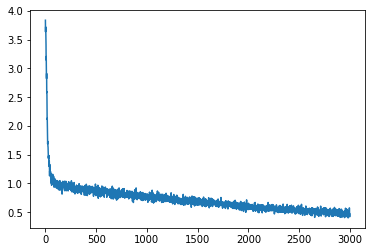

In [116]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], 
                                                             len(loss_track)*batch_size, 
                                                             batch_size))